 # CAM 

This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [1]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

## Import
Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (683, 683)


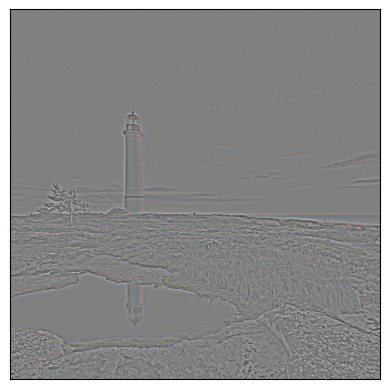

In [2]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/640px-Felis_catus-cat_on_snow.jpg'

lighthouse_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_original.jpg?raw=true'
lighthouse_90deg_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_90deg.jpg?raw=true'
lighthouse_blur_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_blur.jpg?raw=true'
lighthouse_highpass_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_highpass.jpg?raw=true'
lighthouse_mix_channel_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_mix_channel.jpg?raw=true'
lighthouse_noise_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_noise.jpg?raw=true'
lighthouse_equalized_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse%20equalized.jpg?raw=true'

lighthouse_url_list = [
    lighthouse_url,
    lighthouse_90deg_url,
    lighthouse_blur_url,
    lighthouse_highpass_url,
    lighthouse_mix_channel_url,
    lighthouse_noise_url,
    lighthouse_equalized_url   
]

description = ['Original', '90deg', 'Gaussian blur', 'Highpass filtered', 'Mixed color channels', 'Noise', 'Hist.equalized']

lighthouse_image_list = []
for i in range(len(lighthouse_url_list)):
    
    try:
        with Image.open(urlopen(lighthouse_url_list[i])) as im:
            # The following fixes some problems when loading images:
            # https://stackoverflow.com/a/64598016
            lighthouse_image_list.append(im.convert("RGB"))
    except (URLError, OSError):
        print("please provide a valid URL or local path")


 
print(f"{lighthouse_image_list[3].mode} image of size {lighthouse_image_list[3].size}")
plt.imshow(np.asarray(lighthouse_image_list[3]))
plt.xticks([])
plt.yticks([])
plt.show()

## Preprocess 

In [3]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [4]:
lighthouse_tensors = []
for i in range(len(lighthouse_image_list)):
    lighthouse_tensors.append(preprocess(lighthouse_image_list[i]))

In [5]:
prediction_var_list = []
for i in range(len(lighthouse_image_list)):
    prediction_var_list.append(Variable((lighthouse_tensors[i].unsqueeze(0)), requires_grad=True))


## Load model

In [6]:
model = models.resnet18(pretrained=True)

/Users/falk/Documents/python_projects/DL4IA_assignment_4/Explainable-Artificial-Intelligence/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/falk/Documents/python_projects/DL4IA_assignment_4/Explainable-Artificial-Intelligence/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [9]:
final_layer = model._modules.get('layer4')

In [10]:
activated_features = SaveFeatures(final_layer)

## Make prediction

In [11]:
pred_probabilities_list = []

for i in range(len(lighthouse_tensors)):
    prediction = model(prediction_var_list[i])
    pred_probabilities_list.append(F.softmax(prediction).data.squeeze())
    activated_features.remove()



/var/folders/gz/cp34mcp54pn6gmdlbwkdhdwh0000gn/T/ipykernel_6069/2287866501.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities_list.append(F.softmax(prediction).data.squeeze())


In [12]:
for i in range(len(lighthouse_tensors)):
    topk(pred_probabilities_list[i],1)
    print(topk(pred_probabilities_list[i],1))

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
 
437: 'beacon, lighthouse, beacon light, pharos',

In [13]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [14]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [15]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1.2041e-02,  9.04

In [16]:
overlay_list = []
class_list = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],1)[1].int()
    overlay_list.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list.append(class_idx)
    print(topk(pred_probabilities_list[i],1))

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


## Plot heatmap of predicted class

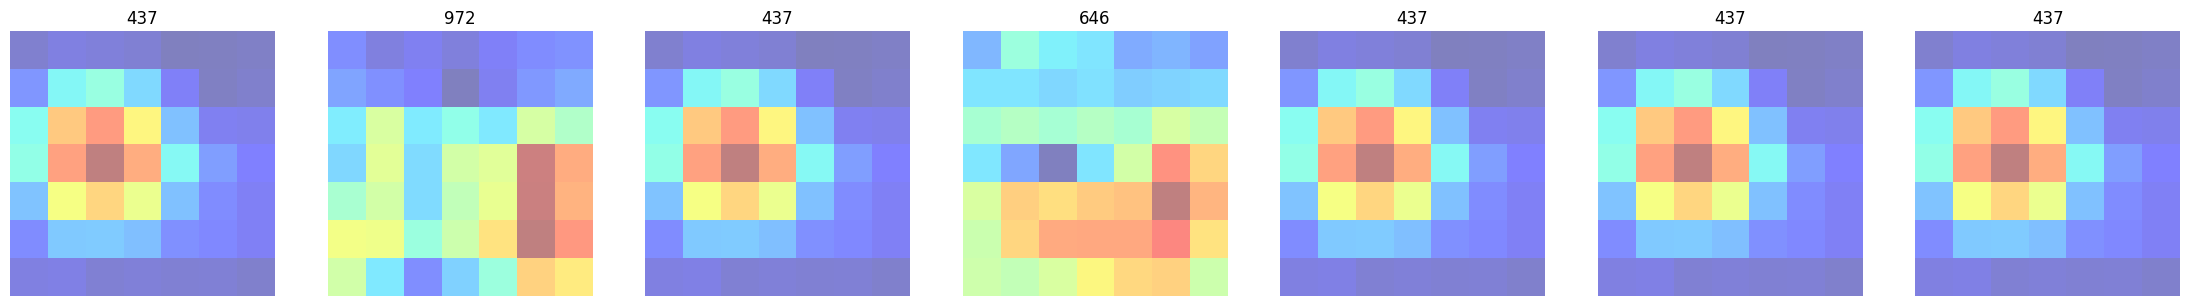

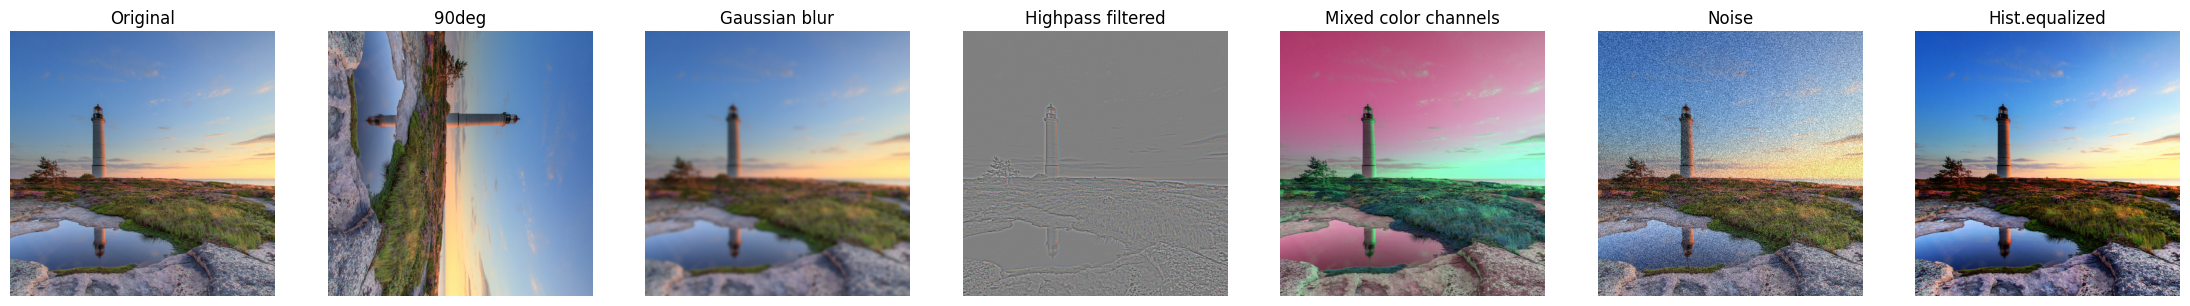

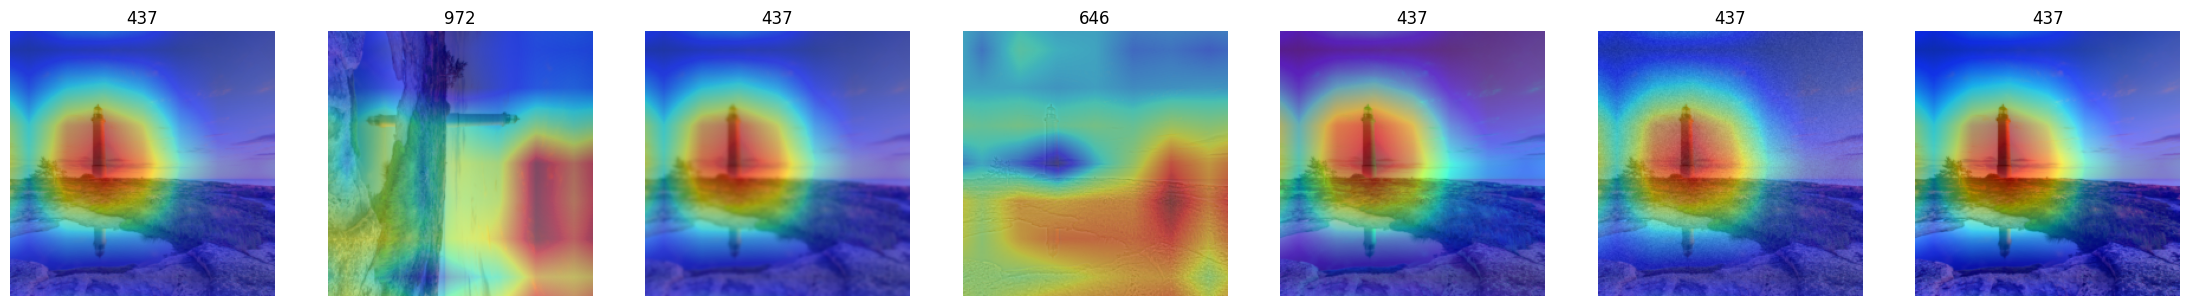

In [17]:
def plot_heatmap(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i][0], alpha=0.5, cmap='jet')
        ax.set_title(titles[i].item())
        ax.axis('off')
    
    plt.show()
    
def plot_images(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(description[i])
        ax.axis('off')
    
    plt.show()

def plot_images_overlay(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(lighthouse_image_list[i]))
        ax.imshow(skimage.transform.resize(overlay_list[i][0], lighthouse_tensors[i].shape[1:3]), alpha=0.5, cmap='jet');
        ax.set_title(titles[i].item())
        ax.axis('off')
    
    plt.show()


plot_heatmap(overlay_list, class_list)
plot_images(lighthouse_image_list, class_list)
plot_images_overlay(lighthouse_image_list, class_list)

 437: 'beacon, lighthouse, beacon light, pharos',
 
 972: 'cliff, drop, drop-off',
 
 646: 'maze, labyrinth',
 

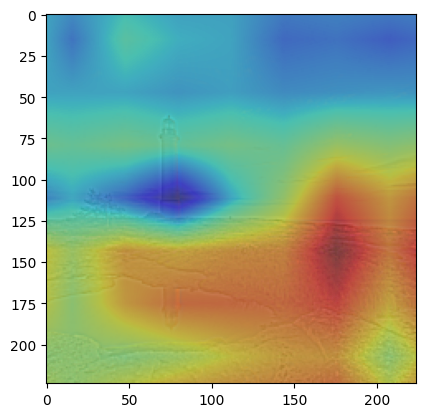

In [18]:
imshow(display_transform(lighthouse_image_list[3]))
imshow(skimage.transform.resize(overlay_list[3][0], lighthouse_tensors[0].shape[1:3]), alpha=0.5, cmap='jet');

## Plot heatmap of second predected class

In [19]:
overlay_list_sec = []
class_list_sec = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],2)[1].int()
    print(topk(pred_probabilities_list[i],2))
    class_idx = class_idx[1]
    overlay_list_sec.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list_sec.append(class_idx)

    


torch.return_types.topk(
values=tensor([9.9725e-01, 3.2850e-04]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([0.6106, 0.0701]),
indices=tensor([972, 976]))
torch.return_types.topk(
values=tensor([0.7377, 0.0419]),
indices=tensor([437, 975]))
torch.return_types.topk(
values=tensor([0.1081, 0.0844]),
indices=tensor([646,  50]))
torch.return_types.topk(
values=tensor([0.9865, 0.0021]),
indices=tensor([437, 460]))
torch.return_types.topk(
values=tensor([0.9774, 0.0043]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([9.9873e-01, 2.8490e-04]),
indices=tensor([437, 497]))


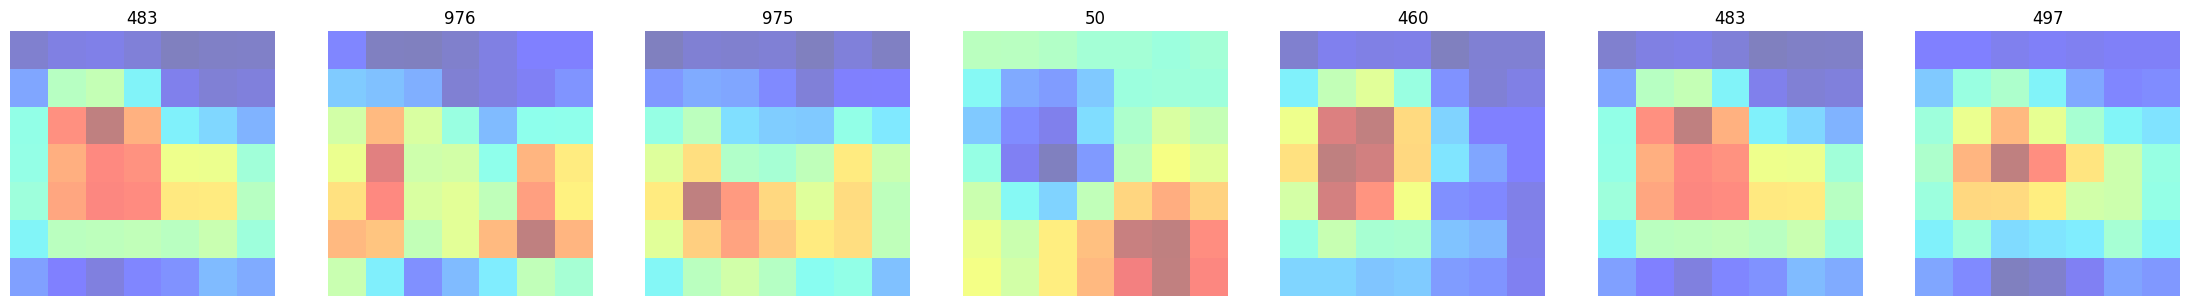

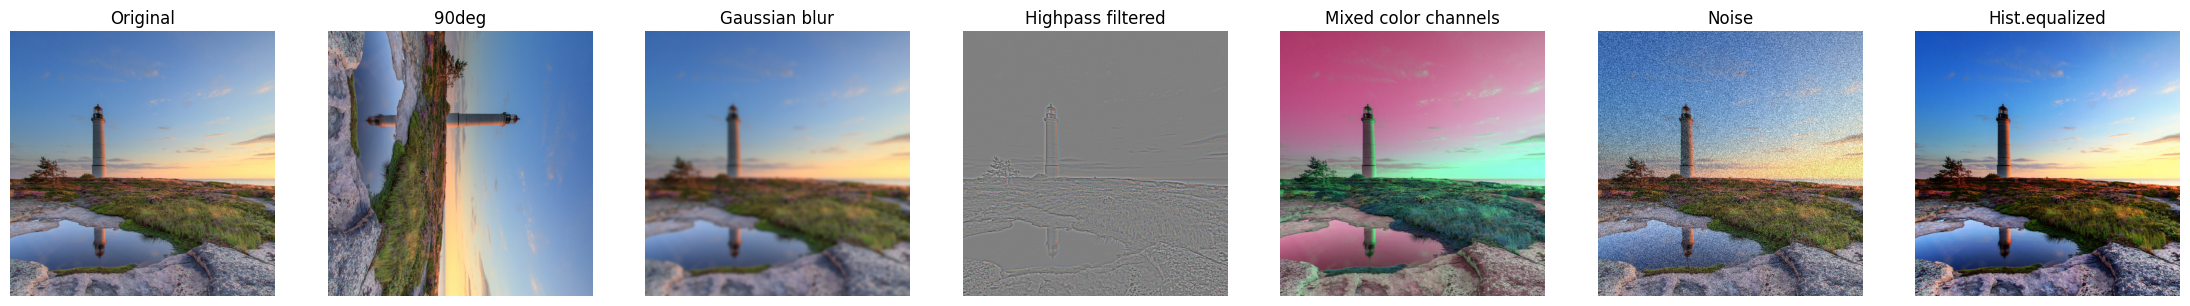

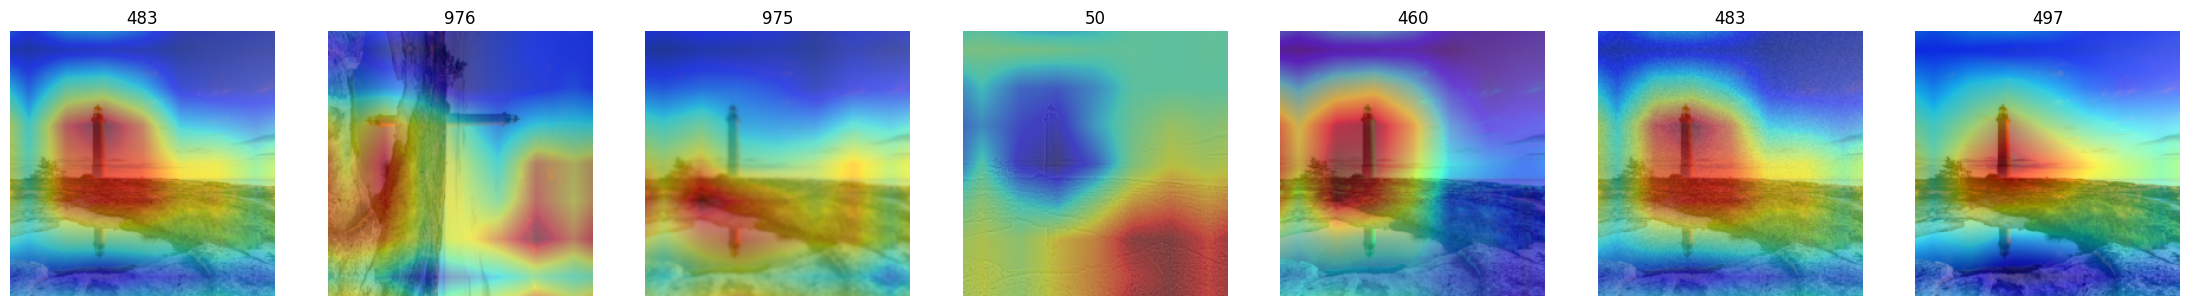

In [20]:
def plot_heatmap(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i][0], alpha=0.5, cmap='jet')
        ax.set_title(titles[i].item())
        ax.axis('off')
    
    plt.show()
    
def plot_images(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(description[i])
        ax.axis('off')
    
    plt.show()

def plot_images_overlay(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(lighthouse_image_list[i]))
        ax.imshow(skimage.transform.resize(overlay_list_sec[i][0], lighthouse_tensors[i].shape[1:3]), alpha=0.5, cmap='jet');
        ax.set_title(titles[i].item())
        ax.axis('off')
    
    plt.show()


plot_heatmap(overlay_list_sec, class_list_sec)
plot_images(lighthouse_image_list, class_list_sec)
plot_images_overlay(lighthouse_image_list, class_list_sec)

Second choice

483: 'castle' [3.2850e-04]

976: 'promontory, headland, head, foreland' [0.0701]

975: 'lakeside, lakeshore', [0.0419]

50: 'American alligator, Alligator mississipiensis',[0.0419]

460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', [0.0021]

483: 'castle', [0.0043]

497: 'church, church building', [2.8490e-04]



## Plot heatmap of other classes
Lets check the heat map for some other classes 

*   527: 'desktop computer'
*   587: 'hammer'
*   497: 'church, church building',


In [21]:
other_class = 497

overlay_list_otherclass = []
class_list_otherclass = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],2)[1].int()
    print(topk(pred_probabilities_list[i],2))
    class_idx = class_idx[1]
    overlay_list_otherclass.append(getCAM(activated_features.features, weight_softmax, other_class))
    class_list_otherclass.append(class_idx)

torch.return_types.topk(
values=tensor([9.9725e-01, 3.2850e-04]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([0.6106, 0.0701]),
indices=tensor([972, 976]))
torch.return_types.topk(
values=tensor([0.7377, 0.0419]),
indices=tensor([437, 975]))
torch.return_types.topk(
values=tensor([0.1081, 0.0844]),
indices=tensor([646,  50]))
torch.return_types.topk(
values=tensor([0.9865, 0.0021]),
indices=tensor([437, 460]))
torch.return_types.topk(
values=tensor([0.9774, 0.0043]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([9.9873e-01, 2.8490e-04]),
indices=tensor([437, 497]))


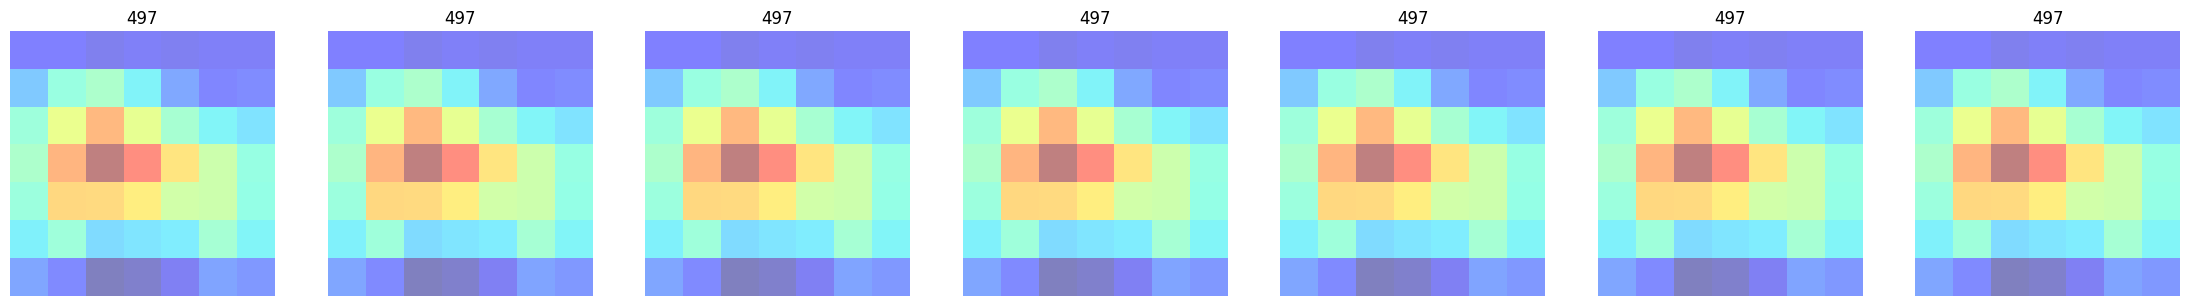

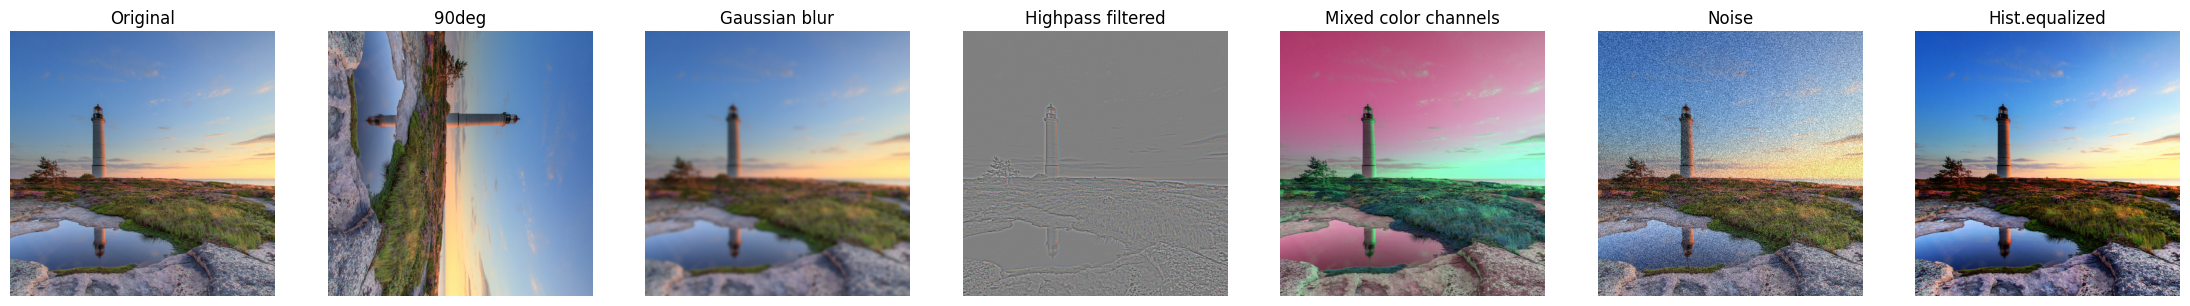

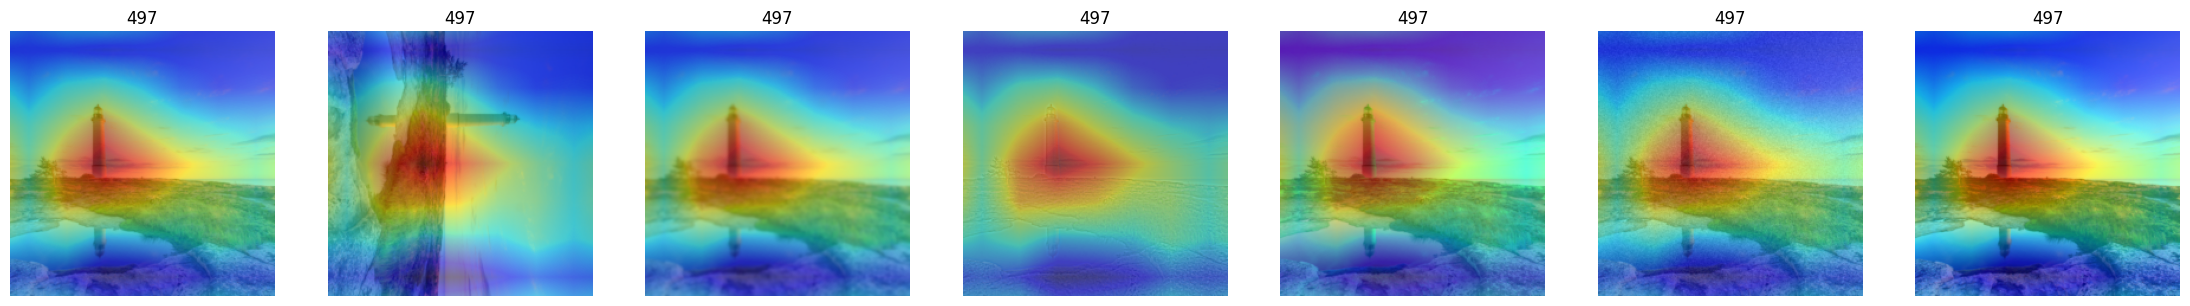

In [22]:
def plot_heatmap(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i][0], alpha=0.5, cmap='jet')
        ax.set_title(other_class)
        ax.axis('off')
    
    plt.show()
    
def plot_images(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(description[i])
        ax.axis('off')
    
    plt.show()

def plot_images_overlay(images, titles):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    
    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(lighthouse_image_list[i]))
        ax.imshow(skimage.transform.resize(overlay_list_otherclass[i][0], lighthouse_tensors[i].shape[1:3]), alpha=0.5, cmap='jet');
        ax.set_title(other_class)
        ax.axis('off')
    
    plt.show()


plot_heatmap(overlay_list_otherclass, class_list_sec)
plot_images(lighthouse_image_list, class_list_sec)
plot_images_overlay(lighthouse_image_list, class_list_otherclass)